In [229]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi, voronoi_plot_2d
import itertools

from functions_voronoi import voronoi_finite_polygons_2d, voronoi_polygons

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [230]:
INPUT_WIDTH = 800
INPUT_HEIGHT = 400

in_points = np.array([[x, y] for x in range(INPUT_WIDTH) for y in range(INPUT_HEIGHT)])
in_points.shape

(320000, 2)

In [261]:
N_points = 5

kmeans = KMeans(n_clusters=N_points, random_state=0)
clusters = kmeans.fit_predict(in_points)
new_points = np.array([np.mean(in_points[clusters == curr], axis=0) for curr in set(clusters)])
new_points += np.array([[x_r, y_r] for x_r,y_r in zip(np.random.randint(N_points, size=N_points), 
                                                      np.random.random(N_points)+np.random.randint(N_points, size=N_points))])
new_points.shape

(5, 2)

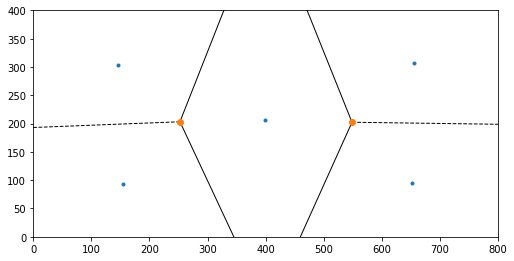

In [293]:
vor = Voronoi(new_points)

fig, ax = plt.subplots()
fig = voronoi_plot_2d(vor, ax, show_vertices=True)
ax.set_xlim((0, INPUT_WIDTH))
ax.set_ylim((0, INPUT_HEIGHT))
fig.set_size_inches(INPUT_WIDTH/96.0, INPUT_HEIGHT/96.0)

In [294]:
polygons = voronoi_polygons(new_points)
# polygons = crop_axis(polygons, range_x=[0, INPUT_WIDTH], range_y=[0, INPUT_HEIGHT])

x_polygs, y_polygs = [], []
for polyg in polygons:
    x_polygs.append(list(polyg[:, 0]) + [None])
    y_polygs.append(list(polyg[:, 1]) + [None])


x_polygs = list(itertools.chain(*x_polygs))
y_polygs = list(itertools.chain(*y_polygs))

In [295]:
import plotly.graph_objects as go

fig = go.Figure(go.Scatter(x=x_polygs, y=y_polygs, mode='lines+markers'))
fig.add_trace(go.Scatter(x=[0, 0, INPUT_WIDTH, INPUT_WIDTH, 0], 
           y=[0, INPUT_HEIGHT, INPUT_HEIGHT, 0, 0], mode='lines+markers'))
# fig.update_layout(yaxis_range=[0, INPUT_HEIGHT], xaxis_range=[0, INPUT_WIDTH])
fig.show()

In [296]:
def is_segments_intersect(seg_1, seg_2):
    v1, v2 = seg_1
    u1, u2 = seg_2

    M = np.array([v1 - v2, u2 - u1]).T
    if np.linalg.matrix_rank(M) < 2:
        return False

    a, b = np.linalg.inv(M).dot(u2 - v2)

    return (0 < a < 1) and (0 < b < 1)


def line_intersection(line1, line2):
    xdiff = (line1[0][0] - line1[1][0], line2[0][0] - line2[1][0])
    ydiff = (line1[0][1] - line1[1][1], line2[0][1] - line2[1][1])

    def det(a, b):
        return a[0] * b[1] - a[1] * b[0]

    div = det(xdiff, ydiff)
    d = (det(*line1), det(*line2))
    x = det(d, xdiff) / div
    y = det(d, ydiff) / div
    return x, y

In [302]:
def get_new_polygon(polyg, range_x, range_y):
    x1, x2, = range_x
    y1, y2 = range_y
    A, B, C, D = (x1, y1), (x1, y2), (x2, y2), (x2, y1)

    new_polyg = polyg.copy()
    
    for vector in zip(polyg, np.vstack((polyg, polyg[0]))[1:]):
        for line in zip([A, B, C, D], [B, C, D, A]):  
            
            crossed = is_segments_intersect(np.array(vector), np.array(line))
            if crossed:
                print('crossed', vector, line)
                intersected_line = line_intersection(vector, line)
                out_vector = get_out_point(vector)                
                index = np.where(np.equal(polyg, out_vector).sum(axis=1)>0)
                
                print('index ', index)
                index = index[0]
                if len(index) >0 :
                    new_polyg[index[0]] = intersected_line
#                     print(polyg[index[0]], intersected_line)
#     print(new_polyg)
    return new_polyg

def get_out_point(vector):
    for vec in vector:
        is_curr_point = vec[0]<x1 or vec[0] > x2 or vec[1] < y1 or vec[1]>y2
#         print('vec ', vec)
#         print(is_curr_point)
        if is_curr_point:
            return vec

range_x=(0, INPUT_WIDTH)
range_y=(0, INPUT_HEIGHT)

polyg = polygons[1]
# print(polyg)
# print('\nnew')
get_new_polygon(polyg, range_x, range_y)

crossed (array([ 403.52938732, -127.97211593]), array([252.4687137, 203.1824569])) ((800, 0), (0, 0))
index  (array([1]),)
crossed (array([252.4687137, 203.1824569]), array([-868.81609906,  158.11508016])) ((0, 0), (0, 400))
index  (array([3]),)


array([[  406.54431348, -1250.1582012 ],
       [  345.15316177,     0.        ],
       [  252.4687137 ,   203.1824569 ],
       [   -0.        ,   193.0350773 ]])

In [303]:
def form_x_y_polygons(polygons, range_x, range_y):
    x_polygs, y_polygs = [], []
    for polyg in polygons:
        x_polygs.append(list(polyg[:, 0])+[None])
        y_polygs.append(list(polyg[:, 1])+[None])

    x_polygs = list(itertools.chain(*x_polygs))
    y_polygs = list(itertools.chain(*y_polygs))
    return x_polygs, y_polygs


def crop_axis(polygons, range_x, range_y):
    new_polygons = [get_new_polygon(polyg, range_x, range_y) for polyg in polygons]
    return new_polygons


polygons = voronoi_polygons(new_points)
cropped_polygons = crop_axis(polygons, range_x=(0, INPUT_WIDTH), range_y=(0, INPUT_HEIGHT))
cropped_polygons

crossed (array([399.00530831, 584.70757235]), array([548.47243172, 202.33397309])) ((0, 400), (800, 400))
index  (array([0]),)
crossed (array([548.47243172, 202.33397309]), array([1670.54709828,  186.2360724 ])) ((800, 400), (800, 0))
index  (array([2]),)
crossed (array([ 403.52938732, -127.97211593]), array([252.4687137, 203.1824569])) ((800, 0), (0, 0))
index  (array([1]),)
crossed (array([252.4687137, 203.1824569]), array([-868.81609906,  158.11508016])) ((0, 0), (0, 400))
index  (array([3]),)
crossed (array([1670.54709828,  186.2360724 ]), array([548.47243172, 202.33397309])) ((800, 400), (800, 0))
index  (array([1]),)
crossed (array([548.47243172, 202.33397309]), array([ 403.52938732, -127.97211593])) ((800, 0), (0, 0))
index  (array([3]),)
crossed (array([-868.81609906,  158.11508016]), array([252.4687137, 203.1824569])) ((0, 0), (0, 400))
index  (array([0]),)
crossed (array([252.4687137, 203.1824569]), array([399.00530831, 584.70757235])) ((0, 400), (800, 400))
index  (array([2]

[array([[ 471.2061861 ,  400.        ],
        [ 548.47243172,  202.33397309],
        [ 800.        ,  198.72542017],
        [ 394.10975062, 1706.88702915]]),
 array([[  406.54431348, -1250.1582012 ],
        [  345.15316177,     0.        ],
        [  252.4687137 ,   203.1824569 ],
        [   -0.        ,   193.0350773 ]]),
 array([[  406.54431348, -1250.1582012 ],
        [  800.        ,   198.72542017],
        [  548.47243172,   202.33397309],
        [  459.68538534,     0.        ]]),
 array([[   0.        ,  193.0350773 ],
        [ 252.4687137 ,  203.1824569 ],
        [ 328.06261658,  400.        ],
        [ 394.10975062, 1706.88702915]]),
 array([[459.68538534,   0.        ],
        [252.4687137 , 203.1824569 ],
        [471.2061861 , 400.        ],
        [548.47243172, 202.33397309]])]

In [305]:
x_polygs, y_polygs = form_x_y_polygons(cropped_polygons, range_x, range_y)

fig = go.Figure(go.Scatter(x=x_polygs, y=y_polygs, mode='lines+markers'))
fig.update_layout(yaxis_range=[0, INPUT_HEIGHT], xaxis_range=[0, INPUT_WIDTH])
fig.show()